# salvo_uaf_20250204

Notebook for producing snow and surface energy balance evolution figures

In [112]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import warnings

from modules.salvoimport import load_salvo_data_str, load_gml_albedo, preprocess_rap
from modules.salvoproc import line_date_agg

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
# Set matplotlib font parameters
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2

## Load data

In [3]:
# Load SALVO data
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile', 'magnaprobe'], sites=['arm', 'beo', 'ice'])

In [4]:
# Load NSA qcrad data
nsa_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsaqcrad", "*.cdf")
ds_nsa = xr.open_mfdataset(nsa_path)
varnames = ['BestEstimate_down_short_hemisp', 'up_short_hemisp',
            'down_long_hemisp', 'up_long_hemisp',
            'Temp_Air', 'wind_speed']
da_list = []
for varname in varnames:
    da_list.append(ds_nsa[varname].where(ds_nsa['qc_'+varname]==0))
df_nsa = xr.merge(da_list).to_dataframe()
df_nsa['timestamp_utc'] = df_nsa.index.tz_localize('UTC')
df_nsa.set_index('timestamp_utc', inplace=True)
df_nsa['albedo'] = df_nsa['up_short_hemisp']/df_nsa['BestEstimate_down_short_hemisp']

In [114]:
# Load GML
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "gml_albedo_rack")
df_gml = load_gml_albedo(dir_path)

df_gml['incident_bestestimate_W_m2'] = df_gml['direct_solar_W_m2']*np.cos(df_gml['zen']*np.pi/180) + df_gml['diffuse_solar_W_m2']
df_gml['incident_bestestimate_W_m2_qc'] = df_gml['direct_solar_W_m2_qc'] + df_gml['diffuse_solar_W_m2_qc']
df_gml['albedo'] = df_gml['reflected_solar_W_m2'] / df_gml['incident_bestestimate_W_m2']
df_gml['diffuse_frac'] = df_gml['diffuse_solar_W_m2']/df_gml['incident_bestestimate_W_m2']

In [6]:
# Load NSA ecor data
ecr_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsa30ecor", "*.cdf")
ds_ecr = xr.open_mfdataset(ecr_path)

In [7]:
varnames = ['h', 'lv_e',
            'mean_t', 'wind_spd']
da_list = []
for varname in varnames:
    da_list.append(ds_ecr[varname].where(ds_ecr['qc_'+varname]==0))
df_ecr = xr.merge(da_list).to_dataframe()
df_ecr['timestamp_utc'] = df_ecr.index.tz_localize('UTC')
df_ecr.set_index('timestamp_utc', inplace=True)

In [11]:
# Load snow pinger data
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsasrs")
filename = "nsasrsC1.a1.2024*.000000.nc"

ds_srC = xr.open_mfdataset(os.path.join(dir_path, filename))

In [12]:
# Filter snow pinger data by data quality
# keep both: 152-210 = good measurement quality numbers, 210-300 = reduced echo signal strength

df_list = []

for i in np.arange(9)+1:
    df_list.append(ds_srC['distance_'+str(i)].where(
        (ds_srC['data_quality_'+str(i)]>=152) 
        & (ds_srC['data_quality_'+str(i)]<=300)).to_dataframe()/100)

df_C1 = pd.concat(df_list, axis=1)
df_C1['timestamp_utc'] = df_C1.index.tz_localize('UTC')
df_C1.set_index('timestamp_utc', inplace=True)

In [18]:
df_C1_snow_height = df_C1.resample('D').mean().max() - df_C1

In [75]:
# Create Atmospheric flux dataframe
# Create net flux dataframe
df_gml_temp = df_gml.copy()
df_gml_temp['absorbed_solar_W_m2'] = df_gml_temp['incident_bestestimate_W_m2'] - df_gml_temp['reflected_solar_W_m2']
df_gml_temp = df_gml_temp[(df_gml_temp.incident_bestestimate_W_m2_qc == 0) &
                          (df_gml_temp.reflected_solar_W_m2_qc == 0)]
df_gml_temp[df_gml_temp.incident_bestestimate_W_m2 < df_gml_temp.reflected_solar_W_m2] = np.NaN
df_gml_temp = df_gml_temp.resample('1h').mean()
df_nsa_temp = df_nsa.copy()
df_nsa_temp['net_long'] = df_nsa_temp['down_long_hemisp'] - df_nsa_temp['up_long_hemisp']
df_nsa_temp = df_nsa_temp.resample('1h').mean()
df_ecr_temp = df_ecr.copy()
# Change turbulent flux direction to downwards
df_ecr_temp['h'] *= -1
df_ecr_temp['lv_e'] *= -1
df_ecr_temp = df_ecr_temp.resample('1h').mean()
df_flux = pd.merge(df_nsa_temp[['net_long', 'down_long_hemisp', 'up_long_hemisp']],
                   df_gml_temp[['absorbed_solar_W_m2', 'incident_bestestimate_W_m2', 'albedo']], left_index=True, right_index=True)
df_flux = pd.merge(df_flux, df_ecr_temp[['h', 'lv_e']], left_index=True, right_index=True)
df_flux['net_atm'] = df_flux['net_long'] + df_flux['absorbed_solar_W_m2'] + df_flux['h'] + df_flux['lv_e']
df_flux['net_radiation'] = df_flux['net_long'] + df_flux['absorbed_solar_W_m2']

## Overview of snow and surface energy budget evolution (air T, net atmospheric forcing, snow depth, albedo).

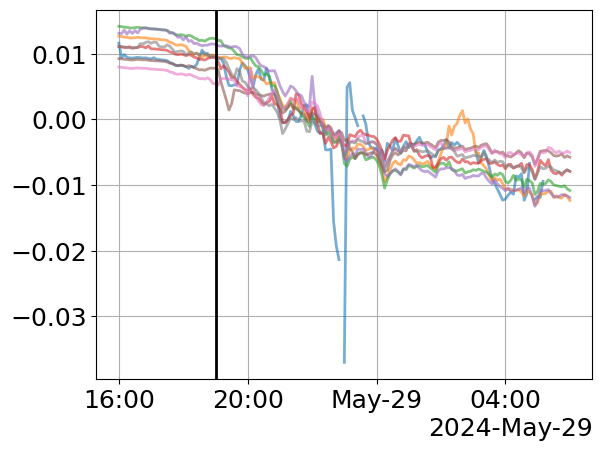

In [56]:
start_date_utc = pd.Timestamp('2024-05-28T16:00:00+0000')
end_date_utc = pd.Timestamp('2024-05-29T06:00:00+0000')
df_temp = df_C1_snow_height[['distance_1', 'distance_2', 'distance_3',
                           'distance_5', 'distance_6',
                           'distance_7', 'distance_8', 'distance_9']
                      ].loc[slice(start_date_utc, end_date_utc)
                      ].resample('5min').mean()
df_temp = df_temp - df_temp.mean()
plt.plot(df_temp, ls='-', alpha=0.6)
plt.axvline(x=pd.Timestamp('2024-05-28T19:00:00+0000'), c='k')
plt.grid()
locator = mdates.AutoDateLocator(minticks=5, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

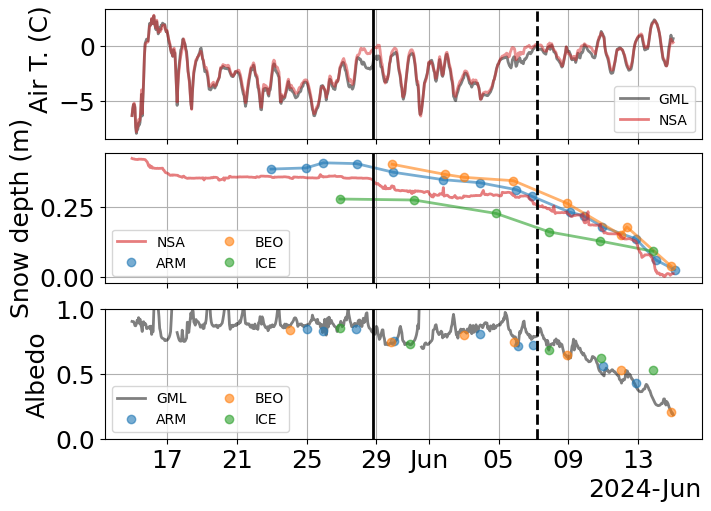

In [70]:
mlt_dt_pinger = pd.Timestamp('2024-05-28T19:00:00+0000')

start_date = pd.Timestamp('2024-05-15T00:00:00')
end_date = pd.Timestamp('2024-06-15T00:00:00')
start_date_utc = pd.Timestamp('2024-05-15T00:00:00+0000')
end_date_utc = pd.Timestamp('2024-06-15T00:00:00+0000')

f, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 5), constrained_layout=True)

# Air temperature
# GML
df_temp = df_gml.query("air_temp_C_qc==0").loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp['air_temp_C'].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[0].plot('timestamp_utc', 'air_temp_C', data=df_temp, c='k', alpha=0.5)
# NSA
df_temp = df_nsa['Temp_Air'].loc[slice(start_date_utc, end_date_utc)
        ].resample('1h').mean()
mlt_dt_persson = (df_temp.rolling(window=24).median().loc[
                  pd.Timestamp('2024-05-22',tz='-0800'):]>-0.1).idxmax()
df_temp = df_temp.reset_index()
nsa_hdl = axs[0].plot('timestamp_utc', 'Temp_Air', data=df_temp, c='tab:red', alpha=0.5)
axs[0].axvline(x=mlt_dt_persson, color='k', linestyle='--')
axs[0].axvline(x=mlt_dt_pinger, color='k', linestyle='-')
axs[0].set_ylabel('    Air T. (C)')
axs[0].grid()

# Snow Depth
# SALVO
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[1].plot('meantime_akdt', 'snow_depth_m', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:blue', ls='-', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[1].plot('meantime_akdt', 'snow_depth_m', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:orange', ls='-', marker='o', alpha=0.6)
site = 'ice'
ice_hdl = axs[1].plot('meantime_akdt', 'snow_depth_m', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:green', ls='-', marker='o', alpha=0.6)
# NSA snow pinger
nsa_hdl = axs[1].plot(df_C1_snow_height[['distance_1', 'distance_2', 'distance_3']
                      ].loc[slice(start_date_utc, end_date_utc)
                      ].resample('1h').mean().mean(axis=1),
            c='tab:red', ls='-', alpha=0.6)

axs[1].set_ylabel('Snow depth (m)')
axs[1].axvline(x=mlt_dt_persson, color='k', linestyle='--')
axs[1].axvline(x=mlt_dt_pinger, color='k', linestyle='-')
axs[1].grid()

# Albedo
# GML
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)"
                      ).loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='k', alpha=0.5)
# SALVO
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:blue', ls='', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:orange', ls='', marker='o', alpha=0.6)
site = 'ice'
ice_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:green', ls='', marker='o', alpha=0.6)

axs[2].axvline(x=mlt_dt_persson, color='k', linestyle='--')
axs[2].axvline(x=mlt_dt_pinger, color='k', linestyle='-')

axs[2].set_ylabel('Albedo')
axs[2].set_ylim([0, 1])
axs[2].grid()
axs[0].legend(handles=[gml_hdl[0], nsa_hdl[0]], 
                       labels=['GML', 'NSA'],
             fontsize=10, ncols=1)
axs[1].legend(handles=[nsa_hdl[0], arm_hdl[0], beo_hdl[0], ice_hdl[0]], 
                       labels=['NSA', 'ARM', 'BEO', 'ICE'],
             fontsize=10, ncols=2)
axs[2].legend(handles=[gml_hdl[0], arm_hdl[0], beo_hdl[0], ice_hdl[0]], 
                       labels=['GML', 'ARM', 'BEO', 'ICE'],
             fontsize=10, ncols=2)

locator = mdates.AutoDateLocator(minticks=10, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

f.savefig(os.path.join('..', 'figures', 'uaf_snow_evo.png'), bbox_inches='tight')

plt.show()

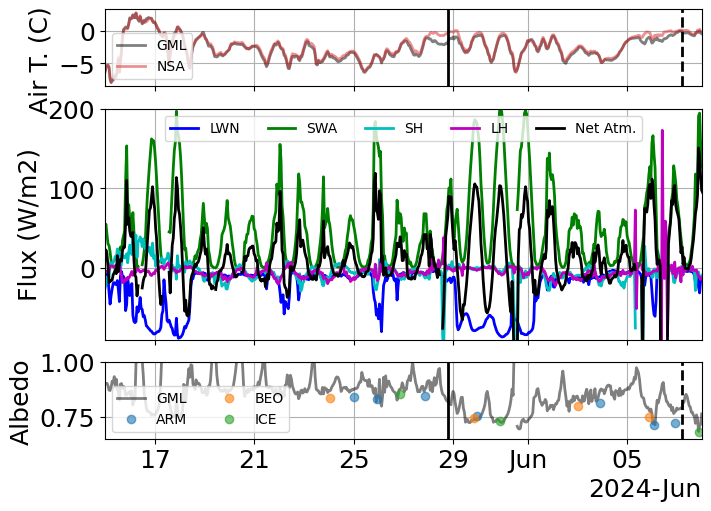

In [110]:
mlt_dt_pinger = pd.Timestamp('2024-05-28T19:00:00+0000')

start_date = pd.Timestamp('2024-05-15T00:00:00')
end_date = pd.Timestamp('2024-06-08T00:00:00')
start_date_utc = pd.Timestamp('2024-05-15T00:00:00+0000')
end_date_utc = pd.Timestamp('2024-06-08T00:00:00+0000')

f, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 5), constrained_layout=True,
                     height_ratios=[1,3,1])

# Air temperature
# GML
df_temp = df_gml.query("air_temp_C_qc==0").loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp['air_temp_C'].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[0].plot('timestamp_utc', 'air_temp_C', data=df_temp, c='k', alpha=0.5)
# NSA
df_temp = df_nsa['Temp_Air'].loc[slice(start_date_utc, end_date_utc)
        ].resample('1h').mean()
df_temp = df_temp.reset_index()
nsa_hdl = axs[0].plot('timestamp_utc', 'Temp_Air', data=df_temp, c='tab:red', alpha=0.5)
axs[0].axvline(x=mlt_dt_persson, color='k', linestyle='--')
axs[0].axvline(x=mlt_dt_pinger, color='k', linestyle='-')
axs[0].set_ylabel('Air T. (C)   ')
axs[0].grid()

# Albedo
# GML
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)"
                      ).loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp[['albedo', 'diffuse_frac']].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='k', alpha=0.5)

# SALVO
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site'),
            c='tab:blue', ls='', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site'),
            c='tab:orange', ls='', marker='o', alpha=0.6)
site = 'ice'
ice_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site'),
            c='tab:green', ls='', marker='o', alpha=0.6)

axs[2].axvline(x=mlt_dt_persson, color='k', linestyle='--')
axs[2].axvline(x=mlt_dt_pinger, color='k', linestyle='-')

axs[2].set_ylabel('Albedo')
axs[2].set_ylim([0.65, 1])
axs[2].set_xlim([start_date, end_date])
axs[2].grid()
axs[0].legend(handles=[gml_hdl[0], nsa_hdl[0]], 
                       labels=['GML', 'NSA'],
             fontsize=10, ncols=1)
axs[2].legend(handles=[gml_hdl[0], arm_hdl[0], beo_hdl[0], ice_hdl[0]], 
                       labels=['GML', 'ARM', 'BEO', 'ICE'],
             fontsize=10, ncols=2)

axs[1].plot(df_flux['net_long'], c='b', label='LWN')
axs[1].plot(df_flux['absorbed_solar_W_m2'], c='g', label='SWA')
axs[1].plot(df_flux['h'], c='c', label='SH')
axs[1].plot(df_flux['lv_e'], c='m', label='LH')
axs[1].plot(df_flux['net_atm'], c='k', label='Net Atm.')
axs[1].grid()
axs[1].set_ylim([-90, 200])
axs[1].legend(fontsize=10, ncols=5, loc='upper center')
axs[1].set_ylabel('Flux (W/m2)')

locator = mdates.AutoDateLocator(minticks=10, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

f.savefig(os.path.join('..', 'figures', 'uaf_SEB.png'), bbox_inches='tight')

plt.show()

In [95]:
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
df_temp

albedo                       meantime_akdt
site date_akdt                                                        
arm  2024-04-19 14:24:00  0.821019 2024-04-19 13:27:57.073170688-08:00
     2024-05-24 14:24:00  0.843656 2024-05-24 15:58:05.714285824-08:00
     2024-05-25 14:24:00  0.834529 2024-05-25 14:57:23.414634240-08:00
     2024-05-27 14:24:00  0.844855 2024-05-27 12:32:21.951219456-08:00
     2024-05-29 14:24:00  0.752966 2024-05-29 15:30:24.878048768-08:00
     2024-06-03 14:24:00  0.812294 2024-06-03 13:47:57.209302528-08:00
     2024-06-05 14:24:00  0.716293 2024-06-05 17:58:36.774193664-08:00
     2024-06-06 14:24:00  0.725462 2024-06-06 14:40:39.512195072-08:00
     2024-06-10 14:24:00  0.564789 2024-06-10 15:15:26.341463552-08:00
     2024-06-12 14:24:00  0.433688 2024-06-12 13:27:13.170731776-08:00
     2024-06-15 14:24:00  0.187999 2024-06-15 14:28:55.714285568-08:00
     2024-06-17 14:24:00  0.160143 2024-06-17 13:12:20.487804672-08:00
beo  2024-04-20 14:24:00  0.836935 2024-04-20 14:21:27.804878080-08:00
     2024-05-23 14:24:00  0.838493 2024-05-23 16:52:49.756097536-08:00
     2024-05-29 14:24:00  0.747160 2024-05-29 12:22:39.622641408-08:00
     2024-06-02 14:24:00  0.800134    2024-06-02 16:41:20.400000-08:00
     2024-06-05 14:24:00  0.749902 2024-06-05 13:17:52.857142784-08:00
     2024-06-08 14:24:00  0.650569 2024-06-08 13:59:49.756097536-08:00
     2024-06-11 14:24:00  0.530559 2024-06-11 16:31:28.636363520-08:00
     2024-06-14 14:24:00  0.210475 2024-06-14 13:25:01.463414528-08:00
     2024-06-17 14:24:00  0.142143    2024-06-17 14:51:03.600000-08:00
ice  2024-04-17 14:24:00  0.804236 2024-04-17 16:28:40.851064064-08:00
     2024-04-21 14:24:00  0.798537 2024-04-21 12:41:30.566037760-08:00
     2024-05-26 14:24:00  0.853458 2024-05-26 13:16:13.170731776-08:00
     2024-05-30 14:24:00  0.731087 2024-05-30 13:47:54.339622656-08:00
     2024-06-07 14:24:00  0.684469 2024-06-07 13:18:24.285714432-08:00
     2024-06-10 14:24:00  0.627305 2024-06-10 12:34:48.292682752-08:00
     2024-06-13 14:24:00  0.534472 2024-06-13 11:39:54.146341376-08:00
     2024-06-15 14:24:00  0.462089 2024-06-15 11:42:37.674418688-08:00
     2024-06-18 14:24:00  0.507229 2024-06-18 13:54:05.454545152-08:00

In [96]:
(1-0.812)/(1-0.844)

1.2051282051282046

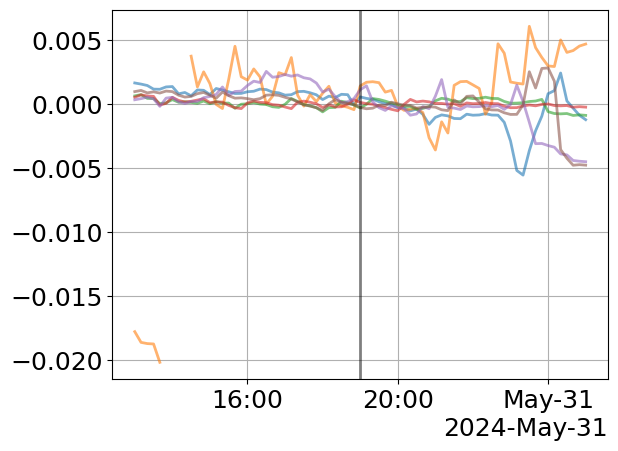

In [102]:
start_date_utc = pd.Timestamp('2024-05-30T13:00:00+0000')
end_date_utc = pd.Timestamp('2024-05-31T01:00:00+0000')
df_temp = df_C1_snow_height[[#'distance_1', 
    'distance_2', #'distance_3',
    'distance_4',                       #'distance_5', 
    'distance_6',
                           'distance_7', 'distance_8', 'distance_9']
                      ].loc[slice(start_date_utc, end_date_utc)
                      ].resample('10min').mean()
df_temp = df_temp - df_temp.mean()
plt.plot(df_temp, ls='-', alpha=0.6)
plt.axvline(x=pd.Timestamp('2024-05-30T19:00:00+0000'), c='k', alpha=0.5)
plt.grid()
locator = mdates.AutoDateLocator(minticks=5, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

In [104]:
df_flux.loc['2024-05-30T20:00:00+00:00': '2024-05-31T01:00:00+00:00']

,net_long,down_long_hemisp,up_long_hemisp,absorbed_solar_W_m2,incident_bestestimate_W_m2,albedo,h,lv_e,net_atm,net_radiation
timestamp_utc,,,,,,,,,,
2024-05-30 20:00:00+00:00,-83.077927,229.194962,312.272888,181.540938,688.359272,0.736305,-5.2290,-7.135000,86.099011,98.463012
2024-05-30 21:00:00+00:00,-84.792488,228.802475,313.594940,197.998990,731.942323,0.729507,-3.5015,-6.184000,103.521002,113.206502
2024-05-30 22:00:00+00:00,-85.870972,228.413467,314.284454,201.378226,737.776559,0.727046,-4.9300,-7.713500,102.863754,115.507254
2024-05-30 23:00:00+00:00,-86.770966,228.215607,314.986603,196.115672,715.870672,0.726052,-5.4235,-9.056499,94.864707,109.344706
2024-05-31 00:00:00+00:00,-86.667000,228.459869,315.126862,182.763414,672.236747,0.728144,-6.3745,-8.211500,81.510414,96.096414
2024-05-31 01:00:00+00:00,-86.208206,228.738693,314.946899,162.798185,610.218185,0.733275,-2.3685,-7.578000,66.643479,76.589979


In [106]:
df_flux.loc['2024-05-28T18:00:00+00:00': '2024-05-29T03:00:00+00:00']

,net_long,down_long_hemisp,up_long_hemisp,absorbed_solar_W_m2,incident_bestestimate_W_m2,albedo,h,lv_e,net_atm,net_radiation
timestamp_utc,,,,,,,,,,
2024-05-28 18:00:00+00:00,-16.860462,299.107208,316.021851,72.647301,410.467301,0.823497,-2.97700,-0.75935,52.050488,55.786838
2024-05-28 19:00:00+00:00,-15.030575,301.705048,316.751862,81.297401,470.970734,0.827312,-0.53935,-0.46450,65.262976,66.266826
2024-05-28 20:00:00+00:00,-14.689256,302.729309,317.386200,100.339340,529.217674,0.810724,3.86750,0.67500,90.192584,85.650085
2024-05-28 21:00:00+00:00,-12.648649,305.207458,317.843323,99.380746,542.209080,0.816851,-0.14960,-0.68900,85.893497,86.732097
2024-05-28 22:00:00+00:00,-18.507473,299.420715,317.901306,111.874573,567.207906,0.806238,-2.43500,-1.46655,89.465550,93.367100
2024-05-28 23:00:00+00:00,-16.454891,300.994781,317.459442,72.474205,426.704030,0.832495,8.01700,-2.81395,61.222364,56.019314
2024-05-29 00:00:00+00:00,-11.744645,305.476257,317.304962,57.495340,382.183674,0.867293,-1.46650,-4.13750,40.146696,45.750695
2024-05-29 01:00:00+00:00,-11.547343,304.812012,316.359344,37.163628,258.140295,0.857414,-1.51300,-0.90765,23.195635,25.616285
2024-05-29 02:00:00+00:00,-17.768518,298.595642,316.364166,54.270006,298.478339,0.819765,1.43000,-3.29900,34.632488,36.501487


Text(0, 0.5, 'Air Temp. (C)')

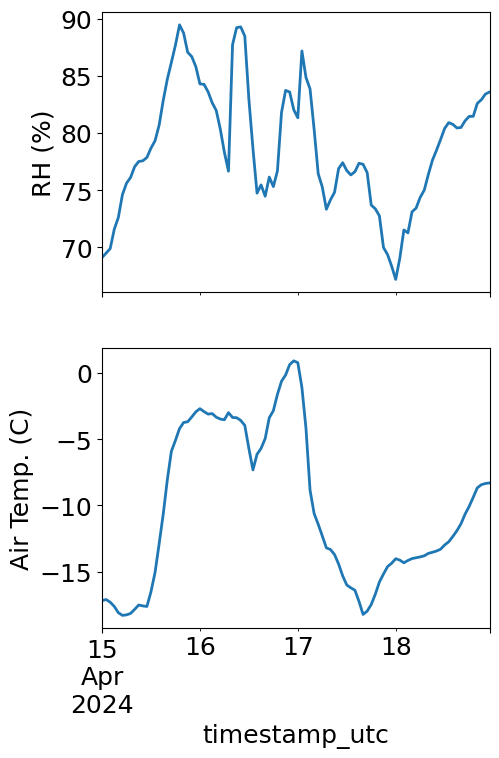

In [123]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
df_gml.resample('1h').mean().loc[slice('2024-04-15','2024-04-18')]['rh'].plot(ax=axs[0])
axs[0].set_ylabel('RH (%)')

df_gml.resample('1h').mean().loc[slice('2024-04-15','2024-04-18')]['air_temp_C'].plot(ax=axs[1])
axs[1].set_ylabel('Air Temp. (C)')

In [121]:
df_gml.columns

Index(['zen', 'global_solar_W_m2', 'global_solar_W_m2_qc',
       'reflected_solar_W_m2', 'reflected_solar_W_m2_qc', 'direct_solar_W_m2',
       'direct_solar_W_m2_qc', 'diffuse_solar_W_m2', 'diffuse_solar_W_m2_qc',
       'air_temp_C', 'air_temp_C_qc', 'rh', 'rh_qc', 'incident_solar_W_m2',
       'incident_solar_W_m2_qc', 'incident_bestestimate_W_m2',
       'incident_bestestimate_W_m2_qc', 'albedo', 'diffuse_frac'],
      dtype='object')